## **Origem dos dados**

Os dados que utilizamos neste projeto foram retirados do site oficial da Ibovespa, pelo fator de confiabilidade e segurança, O Ibovespa é o principal indicador de desempenho das ações negociadas na B3 e reúne as empresas mais importantes do mercado de capitais brasileiro.

Na base utilizada, os dados começam a partir do primeiro dia útil de 2017 e terminam no ultimo dia util de 2023. Optamos por escolher o ano de 2017 porque com isso teríamos uma boa quantidade de dados coletados até o momento da criação da base, fazendo com que assim as analises obtidas tivessem mais embasamento e credibilidade.

Além disso, analisando os resultados obtidos em outros testes,podemos perceber que o custo benefício de recursos utilizados seria mais compensador ao utilizaarmos um ano como 2017 do que um ano antecessor.



In [75]:
# Importando as bibliotecas necessárias
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score, accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

Antes de utilizar e tratar nossos dados, buscamos entender **como eles estavam se comportando**. Buscamos alguma informação, padrão ou tipo de comportamento para entendermos antes de iniciarmos nossas analises e modelos.

Um dos metodos utilizados para avaliar o conjunto de dados foi verificar se o mesmo pode ser considerado **estácionario** ou **não**.

Para isso utilizamos o teste **ADF** (Argument Dickey-Fuler) no código abaixo:


In [76]:
from statsmodels.tsa.stattools import adfuller


**base =** pd.read_csv(data): Lê o arquivo CSV em um DataFrame do pandas.

**base.head():** Exibe as duas primeiras linhas do DataFrame para conferir se os dados foram carregados corretamente.


In [77]:
base = pd.read_csv('https://raw.githubusercontent.com/RodS2/FIAP-Fase-2/main/Dados%20Historicos%20-%20Ibovespa.csv')

In [78]:
base.head()

,Data,Ultimo,Abertura,Maxima,Minima,Vol.,Var%
0,28.12.2023,134.185,134.194,134.392,133.832,"7,81M","-0,01%"
1,27.12.2023,134.194,133.523,134.195,133.328,"6,17M","0,49%"
2,26.12.2023,133.533,132.753,133.645,132.753,"5,15M","0,59%"
3,22.12.2023,132.753,132.182,133.035,132.094,"8,23M","0,43%"
4,21.12.2023,132.182,130.826,132.277,130.822,"8,68M","1,05%"


**base.info()** Exibe um resumo conciso do DataFrame, incluindo o número de entradas, nomes de colunas, tipos de dados e a memória ocupada.
Com isso, conseguirmos verificar a estrutura dos dados e identificar possíveis problemas, como valores ausentes.

In [5]:
# Descobrindo os tipos de cada coluna
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1857 entries, 0 to 1856
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      1857 non-null   object 
 1   Ultimo    1857 non-null   float64
 2   Abertura  1857 non-null   float64
 3   Maxima    1857 non-null   float64
 4   Minima    1857 non-null   float64
 5   Vol.      1857 non-null   object 
 6   Var%      1857 non-null   object 
dtypes: float64(4), object(3)
memory usage: 101.7+ KB


 Converte a coluna 'Data' de string para o tipo datetime. format='%d.%m.%Y' especifica o formato da data no CSV (dia.mês.ano).

 Ordena os dados do DataFrame pela coluna 'Data' em ordem crescente.

In [6]:
# Alterando o time da coluna 'Data' para Datetime e alterando a ordem da base para deixarmos do mais antigo para o mais recente
base['Data'] = pd.to_datetime(base['Data'], format='%d.%m.%Y')
base = base.sort_values(by='Data')


In [7]:
# Tranformando a coluna 'Data' em índice
base.index = base['Data']
base

,Data,Ultimo,Abertura,Maxima,Minima,Vol.,Var%
Data,,,,,,,
2017-01-02,2017-01-02,59.589,60.227,60.227,59.371,"833,73K","-1,06%"
2017-01-03,2017-01-03,61.814,59.631,61.815,59.631,"3,43M","3,73%"
2017-01-04,2017-01-04,61.589,61.811,61.940,61.302,"2,93M","-0,36%"
2017-01-05,2017-01-05,62.071,61.594,62.409,61.594,"3,42M","0,78%"
2017-01-06,2017-01-06,61.665,62.072,62.072,61.396,"2,45M","-0,65%"
...,...,...,...,...,...,...,...
2024-06-24,2024-06-24,122.637,121.343,122.840,121.307,"7,84M","1,07%"
2024-06-25,2024-06-25,122.331,122.634,122.849,121.997,"6,94M","-0,25%"
2024-06-26,2024-06-26,122.641,122.331,122.701,121.402,"8,18B","0,25%"


Define a coluna 'Data' como o índice do DataFrame, o que facilita operações baseadas em datas.

<Axes: xlabel='Data'>

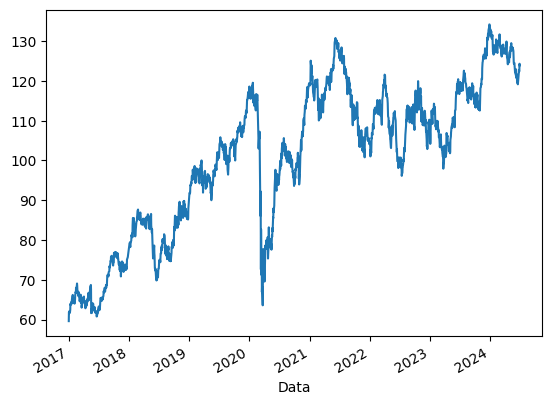

In [8]:
base['Ultimo'].plot()

## **Teste ADF**

In [9]:
X = base.Ultimo.values

In [10]:
result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico:{result[0]}")
print(f"P-Value: {result[1]}")
print("Valores Críticos:")

for key, value in result[4].items():
    print(f"\t{key}:{value}")

Teste ADF
Teste Estatístico:-2.0591731436119693
P-Value: 0.26124484135257653
Valores Críticos:
	1%:-3.43389351006096
	5%:-2.8631052612824286
	10%:-2.5676032900550028


## **Interpretação dos Resultados do Teste ADF**
###Teste Estatístico (Teste Estatístico ADF):

Esse valor é a estatística calculada pelo teste ADF. Ele é comparado com os valores críticos para determinar se a série é estacionária.
Um valor mais negativo sugere evidências mais fortes contra a hipótese nula.

###P-Value (Valor P):

O valor p indica a probabilidade de obter um valor do teste estatístico tão extremo quanto o observado, assumindo que a hipótese nula é verdadeira.
A hipótese nula do teste ADF é que a série temporal tem uma raiz unitária (ou seja, não é estacionária).
Um valor p baixo (normalmente menor que 0,05) sugere que você pode rejeitar a hipótese nula e que a série pode ser estacionária.
Um valor p alto sugere que não há evidências suficientes para rejeitar a hipótese nula e que a série pode não ser estacionária.

###Valores Críticos:

Esses valores são usados como referência para determinar se a estatística do teste é suficientemente negativa para rejeitar a hipótese nula.
Os valores críticos são fornecidos para diferentes níveis de significância (por exemplo, 1%, 5%, e 10%).
Se o valor estatístico do teste ADF for menor (mais negativo) do que os valores críticos, você pode rejeitar a hipótese nula.


###Portanto, com base nesses resultados:

Não rejeitamos a hipótese nula (de que a série tem uma raiz unitária e não é estacionária).
A série temporal não parece ser estacionária com base no teste ADF.



## **Conteúdo da Base**

Base_teste:  Contém os dados entre 2 de janeiro de 2023 e 29 de dezembro de 2023.

Propósito: Separar um período específico dos dados para ser utilizado como conjunto de teste. Este conjunto será usado para avaliar o modelo após o treinamento.

Base_val: contém os dados entre 1 de janeiro de 2022 e 30 de dezembro de 2022.

Propósito: Separar um período específico dos dados para ser utilizado como conjunto de validação. Este conjunto é usado durante o treinamento para ajustar os hiperparâmetros do modelo e evitar overfitting.

Base_treino: contém todos os dados antes de 2 de janeiro de 2022.
Propósito: Separar um período maior dos dados para ser utilizado como conjunto de treinamento. Este conjunto é usado para treinar o modelo.

In [11]:
# Separando a base em treino, teste e validação

# Como a ordem dos dados importa para o treinamento do modelo, não podemos usar train_test_split

base_teste = base[(base['Data'] >= '2023-01-02') & (base['Data'] <= '2023-12-29')]
base_val = base[(base['Data'] >= '2022-01-01') & (base['Data'] <= '2022-12-30')]
base_treino = base[(base['Data'] < '2022-01-02')]

Base_treinamento: contém apenas a coluna 'Último' do conjunto de treinamento, convertida em um array NumPy.

Uso do .iloc: iloc[:, 1:2] seleciona todas as linhas (:) e a segunda coluna (1:2, onde 1 é o índice da coluna 'Último' e 2 é exclusivo, então seleciona apenas a coluna 'Último').
.values: Converte a seleção para um array NumPy.

In [12]:
# Filtrando apenas a coluna de 'Fechamento'
base_treinamento = base_treino.iloc[:, 1:2].values
base_validacao = base_val.iloc[:, 1:2].values

## **Normalização dos Dados**

A normalização é uma etapa importante no pré-processamento de dados para machine learning. Ela transforma os dados para que fiquem em um intervalo específico, geralmente entre 0 e 1, o que pode ajudar a melhorar a performance do modelo.

MinMaxScaler é uma classe da biblioteca sklearn usada para normalizar os dados.
feature_range=(0,1): Especifica que o intervalo desejado para os dados normalizados é entre 0 e 1.

fit_transform ajusta o escalador aos dados de treinamento (fit) e então transforma os dados (transform).
Propósito: A normalização garante que todos os valores estejam dentro do intervalo especificado (0 a 1). Isso é útil para melhorar a convergência durante o treinamento de modelos de machine learning, especialmente redes neurais.

## **Resumo**
Esse trecho de código normaliza os conjuntos de dados de treinamento e validação usando MinMaxScaler para garantir que todos os valores estejam dentro do intervalo [0, 1]. A normalização ajuda a melhorar a eficiência do treinamento do modelo de machine learning.


In [46]:
# Usando o MixMaxScaler para normalizar a base de treinamento e validação
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)
base_validacao_normalizada = normalizador.fit_transform(base_validacao)

MinMaxScaler transforma os dados para que fiquem dentro de um intervalo específico (neste caso, de 0 a 1). A fórmula usada é:

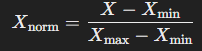

previsores: Lista que armazenará os dados de entrada para o modelo.

preco_real: Lista que armazenará os valores reais que queremos prever.

janela = 90: Define a janela de tempo, ou seja, o número de dias usados para prever o próximo valor. Aqui, estamos usando uma janela de 90 dias.

for i in range(janela, len(base_treinamento_normalizada)): Itera a partir do índice janela até o final do conjunto de dados de treinamento normalizado.

previsores.append(base_treinamento_normalizada[i-janela:i, 0]):
Seleciona uma janela de 90 dias de dados a partir do índice i menos janela até i (ou seja, 90 dias anteriores ao dia i).

base_treinamento_normalizada[i-janela:i, 0] seleciona todos os valores da coluna 0 (a única coluna presente) da janela de 90 dias.
Adiciona essa janela de 90 dias à lista previsores.

preco_real.append(base_treinamento_normalizada[i, 0]):
Seleciona o valor real do dia i (o próximo valor após a janela de 90 dias).
Adiciona esse valor à lista preco_real.

## **Resumo do código**
Este trecho de código cria os conjuntos de dados de treinamento para uma LSTM:

previsores: Lista de janelas de 90 dias que servem como entrada para o modelo.

preco_real: Lista de valores reais a serem previstos pelo modelo, correspondentes ao dia seguinte após cada janela de 90 dias.

In [14]:
# Separar em fatias de 90 amostras da base de treinamento e tentar prever o próximo dado e assim sucessivamente
previsores = []
preco_real = []
janela = 90
for i in range(janela, len(base_treinamento_normalizada)):
    previsores.append(base_treinamento_normalizada[i-janela:i, 0])
    preco_real.append(base_treinamento_normalizada[i, 0])

previsores_validacao: Lista que armazenará os dados de entrada para o modelo durante a validação.

preco_real_validacao: Lista que armazenará os valores reais que queremos prever durante a validação.

for i in range(janela, len(base_validacao_normalizada)): Itera a partir do índice janela até o final do conjunto de dados de validação normalizado.

previsores_validacao.append(base_validacao_normalizada[i-janela:i, 0]):
Seleciona uma janela de 90 dias de dados a partir do índice i menos janela até i (ou seja, 90 dias anteriores ao dia i).

base_validacao_normalizada[i-janela:i, 0] seleciona todos os valores da coluna 0 (a única coluna presente) da janela de 90 dias.

Adiciona essa janela de 90 dias à lista previsores_validacao.

preco_real_validacao.append(base_validacao_normalizada[i, 0]):
Seleciona o valor real do dia i (o próximo valor após a janela de 90 dias).

Adiciona esse valor à lista preco_real_validacao.

## **Resumo do código:**
Este trecho de código cria os conjuntos de dados de validação para uma LSTM:

previsores_validacao: Lista de janelas de 90 dias que servem como entrada para o modelo durante a validação.

preco_real_validacao: Lista de valores reais a serem previstos pelo modelo, correspondentes ao dia seguinte após cada janela de 90 dias.

Assim, este trecho de código garante que os dados de validação estejam estruturados da mesma forma que os dados de treinamento, permitindo uma avaliação consistente do modelo.


In [15]:
# Separar em fatias de 90 amostras da base de validacao e tentar prever o próximo dado e assim sucessivamente
previsores_validacao = []
preco_real_validacao = []
for i in range(janela, len(base_validacao_normalizada)):
    previsores_validacao.append(base_validacao_normalizada[i-janela:i, 0])
    preco_real_validacao.append(base_validacao_normalizada[i, 0])

Descrição: Converte as listas previsores e preco_real em arrays NumPy.

Propósito: Arrays NumPy são mais eficientes para operações matemáticas e são necessários para a maioria dos frameworks de machine learning.

Descrição: Ajusta a forma dos dados de entrada previsores para que sejam compatíveis com a entrada esperada pela rede neural LSTM.

Parâmetros de np.reshape:
previsores.shape[0]: O número de exemplos (amostras) nos dados de entrada.

previsores.shape[1]: O tamanho da janela de tempo (número de dias na janela, que é 90 neste caso).

1: O número de características por cada passo temporal (neste caso, 1 porque estamos usando apenas a coluna 'Último').

## **Resumo do código**

Este trecho de código converte os dados de entrada (previsores) e os valores reais (preco_real) de listas para arrays NumPy. Em seguida, ajusta a forma dos dados de entrada para que sejam compatíveis com a entrada esperada pela rede LSTM, que requer dados em um formato tridimensional.


In [16]:
# Convertendo para Numpy Array e fazendo reshape da variavel 'previsores' incluindo a linha, coluna e dimensão
previsores, preco_real = np.array(previsores), np.array(preco_real)
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

Descrição: Converte as listas previsores_validacao e preco_real_validacao em arrays NumPy.

Propósito: Arrays NumPy são mais eficientes para operações matemáticas e são necessários para a maioria dos frameworks de machine learning.

Descrição: Ajusta a forma dos dados de entrada previsores_validacao para que sejam compatíveis com a entrada esperada pela rede neural LSTM.

Parâmetros de np.reshape:
previsores_validacao.shape[0]: O número de exemplos (amostras) nos dados de entrada.

previsores_validacao.shape[1]: O tamanho da janela de tempo (número de dias na janela, que é 90 neste caso).

1: O número de características por cada passo temporal (neste caso, 1 porque estamos usando apenas a coluna 'Último').

## **Resumo do código:**

Este trecho de código converte os dados de entrada (previsores_validacao) e os valores reais (preco_real_validacao) de listas para arrays NumPy. Em seguida, ajusta a forma dos dados de entrada para que sejam compatíveis com a entrada esperada pela rede LSTM, que requer dados em um formato tridimensional.

In [17]:
# Convertendo para Numpy Array e fazendo reshape da variavel 'previsores_validacao' incluindo a linha, coluna e dimensão
previsores_validacao, preco_real_validacao = np.array(previsores_validacao), np.array(preco_real_validacao)
previsores_validacao = np.reshape(previsores_validacao, (previsores_validacao.shape[0], previsores_validacao.shape[1], 1))

# **Resumo geral da limpeza e alterações da base:**


Baixamos os dados históricos do Ibovespa e carregamos em um DataFrame do pandas. Convertemos a coluna 'Data' para o formato datetime e ordenamos os dados cronologicamente. Normalizamos os valores numéricos usando MinMaxScaler para garantir que estejam entre 0 e 1. Dividimos os dados em conjuntos de treino, validação e teste com base em intervalos de datas específicos. Para os conjuntos de treino e validação, criamos janelas deslizantes de 90 dias, onde cada janela serve como entrada para prever o próximo valor. Convertendo essas listas para arrays NumPy, garantimos eficiência computacional. Reshape os dados para o formato tridimensional exigido pelas LSTM, onde cada amostra tem a forma (90, 1), representando 90 dias de um único recurso.

**Essas etapas garantem que os dados estejam limpos, normalizados e estruturados corretamente para treinar e validar modelos de aprendizado de máquina.**

In [18]:
previsores.shape[1]

90

In [19]:
previsores_validacao.shape[1]

90

Akira:

## **LSTM para Análise de Dados do IBOVESPA: Uma Abordagem Poderosa**

A escolha da rede neural Long Short-Term Memory (LSTM) para a análise de dados da IBOVESPA se justifica por suas características únicas que a tornam ideal para lidar com dados financeiros.

### **Razões para Escolher o LSTM**

*   **Natureza Sequencial dos Dados:** Dados financeiros, como preços de ações, são sequenciais, com cada ponto relacionado aos anteriores. O LSTM, como rede neural recorrente, é projetado para modelar sequências, capturando dependências temporais.

*   **Memória de Longo Prazo:** O mecanismo de memória do LSTM permite lembrar informações relevantes de longo prazo, crucial para dados financeiros onde eventos passados impactam o futuro.

*   **Flexibilidade e Capacidade de Modelar Padrões Complexos:** O LSTM aprende padrões complexos como tendências, sazonalidades e volatilidade, comuns em dados financeiros não lineares.

*   **Resultados Empíricos:** Estudos e aplicações demonstram o sucesso do LSTM em diversas tarefas financeiras, como previsão de preços, análise de sentimento e detecção de anomalias.

### **Exemplos de Aplicações do LSTM**

*   **Previsão de Preços de Ações:** Prever preços futuros com base no histórico e dados relevantes.

*   **Análise de Sentimento de Mercado:** Identificar o sentimento do mercado em relação a empresas ou setores, auxiliando na previsão de movimentos nos preços.

*   **Detecção de Anomalias:** Identificar padrões incomuns nos dados de negociação, indicando possíveis fraudes ou manipulação.

### **Conclusão**

O LSTM é uma ferramenta poderosa para analisar dados do IBOVESPA, modelando sequências, lembrando informações de longo prazo, aprendendo padrões complexos. Sua flexibilidade e sucesso comprovado o tornam valioso para investidores, analistas e pesquisadores que buscam insights e tomam decisões informadas no mercado financeiro.

In [20]:
# Criando o primeiro modelo
regressor = Sequential()

'''Criando uma camada recorrente LSTM com 100 unidades de memória. O parâmetro return_sequence informa que enviaremos a saída da
função de ativação para a camada de neurônios à frente, além disso informamos no input_shape o tamanho da entrada (90) e a saída (1)'''
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (janela, 1)))
# Criando um dropout que vai zerar aleatoriamente o peso de 30% de alguns neurônios evitando overfitting
regressor.add(Dropout(0.3))

# Criando mais duas camadas recorrentes com 50 unidades de memória
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

# Criando última camada recorrente de saída
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

# Criando uma camada densa com função de ativação linear
regressor.add(Dense(units = 1, activation = 'linear'))

# Criando um CheckPoint para salvar o melhor modelo de acordo com a validação
cp1 = ModelCheckpoint('regressor/', save_best_only=True)

regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])

regressor.summary()

In [21]:
# Realizando o treinamento, inclui os dados de treino e validação com o valor padrão de batch_size
regressor.fit(previsores, preco_real, validation_data=(previsores_validacao, preco_real_validacao), epochs = 100, batch_size = 32, callbacks=[cp1])

In [22]:
# Carregando o melhor modelo
regressor = load_model('regressor/')

In [23]:
# Criando o segundo modelo
regressor2 = Sequential()

'''Criando uma camada recorrente LSTM com 64 unidades de memória. Não foi incluido o parâmetro return_sequence, pois será apenas uma camada LSTM,
além disso informamos no input_shape o tamanho da entrada (90) e a saída (1)'''
regressor2.add(LSTM(units = 64, input_shape = (janela, 1)))

# Criando uma camada densa com função de ativação relu
regressor2.add(Dense(units = 8, activation = 'relu'))

# Criando uma camada densa com função de ativação linear
regressor2.add(Dense(units = 1, activation = 'linear'))

# Criando um CheckPoint para salvar o melhor modelo de acordo com a validação
cp2 = ModelCheckpoint('regressor2/', save_best_only=True)

regressor2.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])

regressor2.summary()

In [24]:
# Realizando o treinamento, inclui os dados de treino e validação com 16 de batch_size
regressor2.fit(previsores, preco_real, validation_data=(previsores_validacao, preco_real_validacao), epochs = 100, batch_size = 16, callbacks=[cp2])

In [25]:
# Carregando o melhor modelo
regressor2 = load_model('regressor2/')

In [26]:
# Criando o terceiro modelo
regressor3 = Sequential()

'''Criando uma camada recorrente LSTM com 64 unidades de memória. Não foi incluido o parâmetro return_sequence, pois será apenas uma camada LSTM,
além disso informamos no input_shape o tamanho da entrada (90) e a saída (1)'''
regressor3.add(LSTM(units = 64, input_shape = (janela, 1)))
# Criando um dropout que vai zerar aleatoriamente o peso de 30% de alguns neurônios evitando overfitting
regressor3.add(Dropout(0.3))

# Criando uma camada densa com função de ativação relu
regressor3.add(Dense(units = 8, activation = 'relu'))
regressor3.add(Dropout(0.3))

# Criando uma camada densa com função de ativação linear
regressor3.add(Dense(units = 1, activation = 'linear'))

# Criando um CheckPoint para salvar o melhor modelo de acordo com a validação
cp3 = ModelCheckpoint('regressor3/', save_best_only=True)

regressor3.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])

regressor3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
# Realizando o treinamento, inclui os dados de treino e validação com 16 de batch_size
regressor3.fit(previsores, preco_real, validation_data=(previsores_validacao, preco_real_validacao), epochs = 100, batch_size = 16, callbacks=[cp3])

Epoch 1/100
72/72 [==============================] - 26s 245ms/step - loss: 0.0797 - mean_absolute_error: 0.2052 - val_loss: 0.0214 - val_mean_absolute_error: 0.1215
Epoch 2/100
72/72 [==============================] - 6s 90ms/step - loss: 0.0493 - mean_absolute_error: 0.1610 - val_loss: 0.0164 - val_mean_absolute_error: 0.1051
Epoch 3/100
72/72 [==============================] - 3s 35ms/step - loss: 0.0357 - mean_absolute_error: 0.1379 - val_loss: 0.0190 - val_mean_absolute_error: 0.1132
Epoch 4/100
72/72 [==============================] - 4s 57ms/step - loss: 0.0247 - mean_absolute_error: 0.1115 - val_loss: 0.0203 - val_mean_absolute_error: 0.1181
Epoch 5/100
72/72 [==============================] - 7s 96ms/step - loss: 0.0191 - mean_absolute_error: 0.0974 - val_loss: 0.0159 - val_mean_absolute_error: 0.1039
Epoch 6/100
72/72 [==============================] - 7s 103ms/step - loss: 0.0194 - mean_absolute_error: 0.0953 - val_loss: 0.0117 - val_mean_absolute_error: 0.0877
Epoch 7/100
7

In [28]:
# Carregando o melhor modelo
regressor3 = load_model('regressor3/')

In [29]:
# Separando a coluna de 'Fechamento' da base de teste
preco_real_teste = base_teste.iloc[:, 1:2].values
preco_real_teste

array([[106.376],
       [104.166],
       [105.334],
       [107.641],
       [108.964],
       [109.13 ],
       [110.817],
       [112.517],
       [111.85 ],
       [110.916],
       [109.213],
       [111.439],
       [112.228],
       [112.922],
       [112.041],
       [111.737],
       [113.028],
       [114.27 ],
       [114.178],
       [112.316],
       [112.273],
       [113.431],
       [112.074],
       [110.141],
       [108.523],
       [108.722],
       [107.83 ],
       [109.951],
       [108.008],
       [108.078],
       [108.836],
       [107.849],
       [109.6  ],
       [109.941],
       [109.177],
       [107.152],
       [107.593],
       [105.798],
       [105.711],
       [104.932],
       [104.385],
       [103.326],
       [103.866],
       [104.7  ],
       [104.228],
       [106.54 ],
       [105.071],
       [103.618],
       [103.121],
       [102.932],
       [102.675],
       [103.435],
       [101.982],
       [100.923],
       [100.998],
       [10

In [30]:
'''Estamos concatenando as bases para quando formos normalizar os valores mínimos e máximos sejam o mesmo.
Caso não concatenassemos, poderia haver difenreças entre o valor '1' de uma base para a outra.'''
base_treino = pd.DataFrame(pd.concat((base_treino['Ultimo'], base_val['Ultimo']), axis = 0))
base_completa = pd.concat((base_treino['Ultimo'], base_teste['Ultimo']), axis = 0)

In [31]:
print("Base treinamento: {}\nBase teste: {}\nBase completa: {}".format(
    len(base_treino), len(base_teste), len(base_completa))
)

Base treinamento: 1485
Base teste: 248
Base completa: 1733


In [32]:
# A variável 'inicio' serve para indicarmos a partir de onde iremos iniciar na base de dados completa
inicio = len(base_completa) - len(base_teste) - janela
entradas = base_completa[inicio: ].values

In [33]:
# Utilizando o reshape, onde o '-1' indica que não vai trabalhar com as linhas e o '1' é a coluna)
entradas = entradas.reshape(-1, 1)

# Usando o MixMaxScaler para normalizar as entradas
entradas = normalizador.transform(entradas)

In [34]:
# Separar em fatias de 90 amostras das entradas e tentar prever o próximo dado e assim sucessivamente
X_teste = []
final = janela + len(base_teste)
for i in range(janela, final):
    X_teste.append(entradas[i-janela:i, 0])

# Convertendo para Numpy Array e fazendo reshape da variavel 'X_teste' incluindo a linha, coluna e dimensão
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

In [35]:
# Efetua as previsões usando o primeiro modelo com base nos dados do 'X_teste'
previsoes = regressor.predict(X_teste)

# Reconverte ("desnormaliza") os dados para R$
previsoes = normalizador.inverse_transform(previsoes)

In [36]:
# Efetua as previsões usando o segundo modelo com base nos dados do 'X_teste'
previsoes2 = regressor2.predict(X_teste)

# Reconverte ("desnormaliza") os dados para R$
previsoes2 = normalizador.inverse_transform(previsoes2)

In [37]:
# Efetua as previsões usando o segundo modelo com base nos dados do 'X_teste'
previsoes3 = regressor3.predict(X_teste)

# Reconverte ("desnormaliza") os dados para R$
previsoes3 = normalizador.inverse_transform(previsoes3)

8/8 [==============================] - 1s 14ms/step


In [38]:
# Métricas para avaliarmos a performance do primeiro modelo
mse = mean_squared_error(preco_real_teste, previsoes)
mae = mean_absolute_error(preco_real_teste, previsoes)
mape = mean_absolute_percentage_error(preco_real_teste, previsoes) * 100
r2 = r2_score(preco_real_teste, previsoes)

print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')
print(f'R^2: {r2:.2f}')

In [39]:
# Métricas para avaliarmos a performance do segundo modelo
mse2 = mean_squared_error(preco_real_teste, previsoes2)
mae2 = mean_absolute_error(preco_real_teste, previsoes2)
mape2 = mean_absolute_percentage_error(preco_real_teste, previsoes2) * 100
r22 = r2_score(preco_real_teste, previsoes2)

print(f'MSE: {mse2:.2f}')
print(f'MAE: {mae2:.2f}')
print(f'MAPE: {mape2:.2f}%')
print(f'R^2: {r22:.2f}')

In [40]:
# Métricas para avaliarmos a performance do terceiro modelo
mse3 = mean_squared_error(preco_real_teste, previsoes3)
mae3 = mean_absolute_error(preco_real_teste, previsoes3)
mape3 = mean_absolute_percentage_error(preco_real_teste, previsoes3) * 100
r23 = r2_score(preco_real_teste, previsoes3)

print(f'MSE: {mse3:.2f}')
print(f'MAE: {mae3:.2f}')
print(f'MAPE: {mape3:.2f}%')
print(f'R^2: {r23:.2f}')

MSE: 4.85
MAE: 1.75
MAPE: 1.50%
R^2: 0.92


In [41]:
preco_real_teste = base_teste.iloc[:, 1:2]
preco_real_teste

,Ultimo
Data,
2023-01-02,106.376
2023-01-03,104.166
2023-01-04,105.334
2023-01-05,107.641
2023-01-06,108.964
...,...
2023-12-21,132.182
2023-12-22,132.753
2023-12-26,133.533


In [42]:
previsoes = pd.DataFrame(previsoes, columns=['Ultimo'])
previsoes['Data'] = base_teste['Data'].values
previsoes.index = previsoes['Data']

previsoes2 = pd.DataFrame(previsoes2, columns=['Ultimo'])
previsoes2['Data'] = base_teste['Data'].values
previsoes2.index = previsoes2['Data']

previsoes3 = pd.DataFrame(previsoes3, columns=['Ultimo'])
previsoes3['Data'] = base_teste['Data'].values
previsoes3.index = previsoes3['Data']

In [43]:
print("Média previsões: R${:.2f}".format(previsoes['Ultimo'].mean()))
print("Média real: R${:.2f}".format(preco_real_teste['Ultimo'].mean()))

plt.figure(figsize=(8, 6))
plt.plot(preco_real_teste['Ultimo'], color = 'red', label = 'Preço real')
plt.plot(previsoes['Ultimo'], color = 'blue', label = 'Previsões')
plt.title('Previsão preço das ações Ibovespa')
plt.xlabel('Tempo (dias)')
plt.ylabel('Valor da ação (R$)')
plt.legend()
plt.show()

In [44]:
print("Média previsões: R${:.2f}".format(previsoes2['Ultimo'].mean()))
print("Média real: R${:.2f}".format(preco_real_teste['Ultimo'].mean()))

plt.figure(figsize=(8, 6))
plt.plot(preco_real_teste['Ultimo'], color = 'red', label = 'Preço real')
plt.plot(previsoes2['Ultimo'], color = 'blue', label = 'Previsões')
plt.title('Previsão preço das ações Ibovespa')
plt.xlabel('Tempo (dias)')
plt.ylabel('Valor da ação (R$)')
plt.legend()
plt.show()

Média previsões: R$113.04
Média real: R$114.20


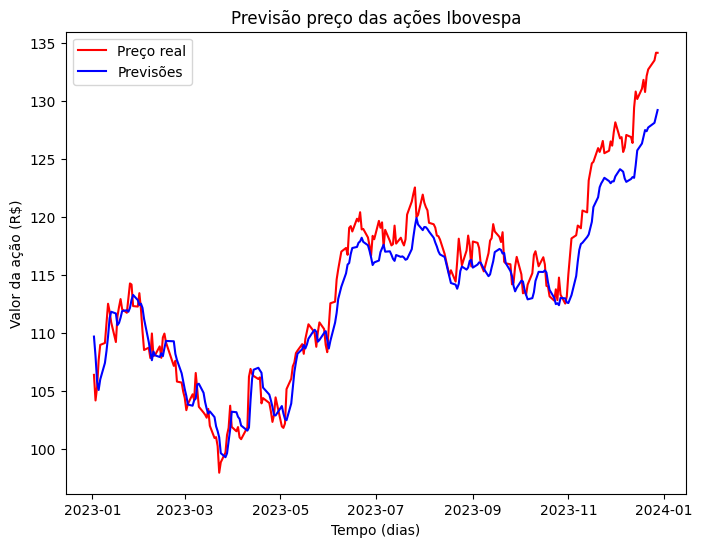

In [45]:
print("Média previsões: R${:.2f}".format(previsoes3['Ultimo'].mean()))
print("Média real: R${:.2f}".format(preco_real_teste['Ultimo'].mean()))

plt.figure(figsize=(8, 6))
plt.plot(preco_real_teste['Ultimo'], color = 'red', label = 'Preço real')
plt.plot(previsoes3['Ultimo'], color = 'blue', label = 'Previsões')
plt.title('Previsão preço das ações Ibovespa')
plt.xlabel('Tempo (dias)')
plt.ylabel('Valor da ação (R$)')
plt.legend()
plt.show()

### **Sobre os dados**

Por mais que no ano de 2023 o índice do Ibovepsa tenha crescido 22,28%, nos primeiros dias houve uma queda grande que nossos 3 modelos não conseguiram prever tão bem. Isso se deve, pois os valores nos últimos dias de 2022 estavam em crescimento e na virada teve uma queda de 3,06% por conta da critia do recém-eleito presidente, Luiz Inácio Lula da Silva, sobre a regra do teto de gastos e prometendo sua revogação.

Fonte: https://www.cnnbrasil.com.br/economia/financas/mercados-2-de-janeiro-de-2023/

### **Sobre os modelos**

Com os modelos treinados podemos perceber que o **primeiro modelo** usando várias camadas ocultas de LSTM teve uma pior previsão dos dados. Provavelmente por conta dos dados sofrerem uma grande influencia externa e não ter uma leitura utilizando apenas a janela de 90 dados.

No **segundo modelo**, teve uma melhora significante mesmo com um modelo mais simples (com apenas uma camade de LSTM e 2 camadas densas) e com um menor tempo de treinamento. Porém há uma alta chance de ter sofrido overffiting.

O **terceiro modelo** é o mesmo que o segundo, porém utilizando o dropout de 30% para evitar overffiting. No R2 teve uma piora de 2%, porém dos modelos testados é o mais recomendado, pais há grandes chances de ser o modelo com poder de generalização dos dados.